In [16]:
%matplotlib inline

In [17]:
from cv2 import *
import numpy as np
from numpy.linalg import pinv, det
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from math import pi, exp

In [36]:
#Settings

#Setting plot size
plt.rcParams['figure.figsize'] = (10.0, 8.0)

IMAGE_NAME = "taj_mahal1.jpg" #Please change this to the name of your test image
IMAGE_SCALE_FACTOR = 1./2
SIGMA_0 = 1.6
SIGMA_SCALE_FACTOR = 2**0.5
SIGMA_MAX = 4*SIGMA_0
KERNEL_SIZE = 15

#Reading in image, rescaling intensities to range [0,1], and finding height and width.
ORIG_IMAGE = imread(IMAGE_NAME, 0)
ORIG_IMAGE = np.divide(ORIG_IMAGE, float(np.max(ORIG_IMAGE)))
ORIG_HEIGHT, ORIG_WIDTH = ORIG_IMAGE.shape

In [37]:
def get_image_with_extrema():
    points = []
    for i in range(3):
        current_image_scale_factor = IMAGE_SCALE_FACTOR**i
        current_img = resize(ORIG_IMAGE, (int(ORIG_WIDTH * current_image_scale_factor), int(ORIG_HEIGHT * current_image_scale_factor)))
        points.extend(get_points_for_image(current_img, current_image_scale_factor))
    points = set(points)
    display = plt.imshow(ORIG_IMAGE, cmap='Greys_r')
    plt.scatter(x=map(lambda (x,y) : y, points), y=map(lambda (x,y) : x, points), c='r', marker='x')
    plt.savefig(IMAGE_NAME[:len(IMAGE_NAME) - 4] + '_with_extrema_filtered.png', bbox_inches='tight', pad_inches=0)
    plt.show()

def get_points_for_image(image, scale_factor):
    blurred_images = [GaussianBlur(image, (KERNEL_SIZE, KERNEL_SIZE), SIGMA_SCALE_FACTOR**i * SIGMA_0) for i in range(5)]
    dog_images = [np.subtract(blurred_images[i], blurred_images[i+1]) for i in range(4)]
    points = []
    for i in [1,2]:
        points.extend(get_filtered_extrema(dog_images[i], dog_images[i-1], dog_images[i+1]))
    display = plt.imshow(image, cmap='Greys_r')
    plt.scatter(x=map(lambda (x,y) : y, points), y=map(lambda (x,y) : x, points), c='r', marker='x')
    plt.show()
    plt.close()
    return map(lambda (x,y) : (int(x/scale_factor), int(y/scale_factor)), points)

def get_filtered_extrema(current_layer, above, below):
    height, width = current_layer.shape
    points = []
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if is_extrema(current_layer[i-1:i+2, j-1:j+2], above[i-1:i+2, j-1:j+2], below[i-1:i+2, j-1:j+2]):
                points.append((i , j))
    return get_all_filtered_points(points, current_layer)

def get_all_filtered_points(points, dog):
    ddx = [der_x(dog), der_y(dog)]
    d2dx2 = [[der_x(i), der_y(i)] for i in ddx]
    filtered = []
    for x,y in points:
        f_point = get_filtered_point(x, y, dog, ddx, d2dx2)
        if f_point:
            if is_not_edge_point(f_point[0], f_point[1], d2dx2):
                filtered.append(f_point)
    return filtered

def is_not_edge_point(x, y, d2dx2):
    hessian = np.array([[m[x,y] for m in row] for row in d2dx2])
    determ = det(hessian)
    tr = hessian[0,0] + hessian[1,1]
    ratio = tr**2/determ
    return (ratio <= 12.1)

def get_filtered_point(x, y, dog, ddx, d2dx2):
    height, width = dog.shape
    if not (x > height - 3 or y > width - 3):
        double_der = -1*pinv([[m[x,y] for m in row] for row in d2dx2])
        single_der = [m[x,y] for m in ddx]
        offset = np.dot(double_der, single_der)
        offset_mod = modify_offset(offset)
        maxima = np.add([x,y], offset)
        if not is_low_contrast(maxima, dog, x, y, single_der):
            point = np.add([x,y], offset_mod)
            if point[0] in range(height - 2) and point[1] in range(width - 2):
                return ((point[0], point[1]))
    return None

def modify_offset(offset):
    result = []
    for i in offset:
        if i > 0.5:
            result.append(1)
        elif i < -0.5:
            result.append(-1)
        else:
            result.append(0)
    return result

def is_low_contrast(maxima, dog, org_x, org_y, ddx):
    val = dog[org_x, org_y] + 0.5*np.dot(ddx, maxima)
    if abs(val) < 0.03:
        return True
    else:
        return False

def der_y(image):
    height, width = image.shape
    image_sub = image[:,1:width]
    derivative = np.subtract(image_sub, image[:,0:width - 1], )
    return derivative

def der_x(image):
    height, width = image.shape
    image_sub = image[1:height, :]
    derivative = np.subtract(image_sub, image[0:height - 1, :])
    return derivative

def is_extrema(current, above, below):
    point = current[1][1]
    height, width = above.shape
    is_min = True
    is_max = True
    for i in range(height):
        for j in range(width):
            if not (is_min or is_max):
                return False
            if is_max and (point <= above[i, j] or point <= below[i,j]):
                is_max = False
            if is_min and (point >= above[i, j] or point >= below[i,j]):
                is_min = False
            if not (i == 1 and j == 1):
                if is_max and point <= current[i, j]:
                    is_max = False
                if is_min and point >= current[i, j]:
                    is_min = False
    if is_min or is_max:
        return True
    else:
        return False


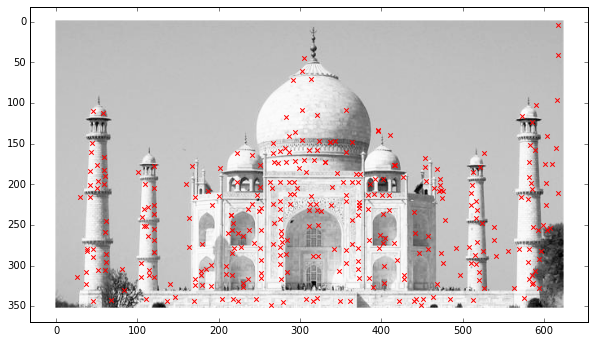

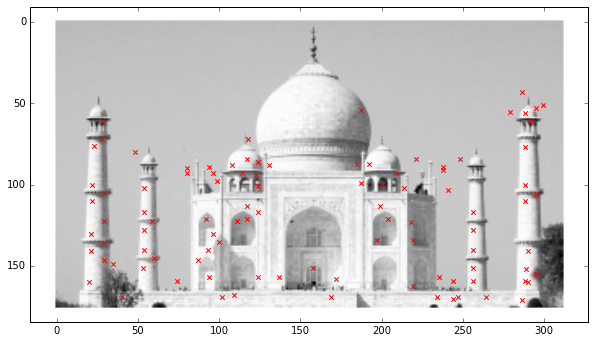

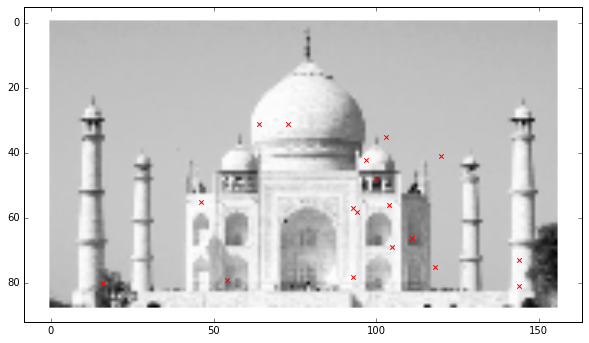

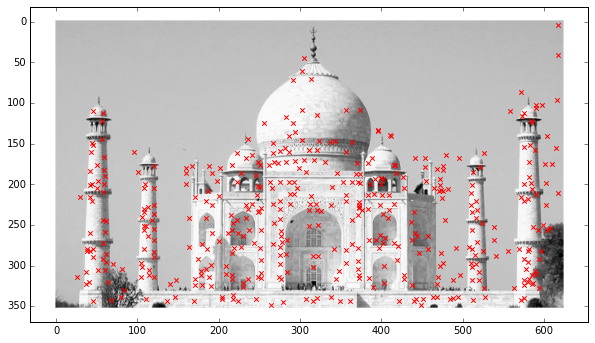

In [38]:
#NOTE 1: The combined image will also be saved in the directory you run this from.

#NOTE 2: It may take some time to run. It does not print any output in the meantime. Please do not exit

#NOTE 3: The images below will be displayed in the order: 
#  i) points from all DOGs for largest to smallest image scale sizes
#  ii) a combined image with points from all the scale sizes plotted on the original image.

get_image_with_extrema()